<a href="https://colab.research.google.com/github/Tanmay240405/paint-By-Numbers/blob/main/PaintByNumbers3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from PIL import Image
from google.colab import files


uploaded = files.upload()
image_path = list(uploaded.keys())[0]

img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (600, 600))

Saving PicsArt_02-28-09.06.27.webp to PicsArt_02-28-09.06.27.webp


Select difficulty:
1 = Easy (fewer, larger regions)
2 = Medium (balanced)
3 = Hard (more detail, smaller regions)
Enter difficulty (1-3): 3
Number of colors (8-20, recommended 12): 12
PAINT-BY-NUMBERS GENERATOR
Settings: 12 colors, Difficulty Level 3

1. Loading and preprocessing image...
   Output size: 3500 x 1991 pixels
2. Applying edge-preserving smoothing...
3. Extracting 12-color palette...
4. Optimizing regions...
   Merging regions smaller than 1393 pixels...

DIFFICULTY ANALYSIS
Total regions to paint: 184
Average region size: 37872 pixels
Smallest region: 1 pixels
Largest region: 525731 pixels

5. Generating paint-by-numbers template...
6. Creating color palette guide...
7. Generating reference image...

GENERATION COMPLETE!

Files saved:
  - 1_original_reference.png (Original image)
  - 2_color_palette.png (Color guide with hex codes)
  - 3_paint_template.png (Main template to print)
  - 4_colored_reference.png (Colored reference thumbnail)

PREVIEW - ORIGINAL IMAGE


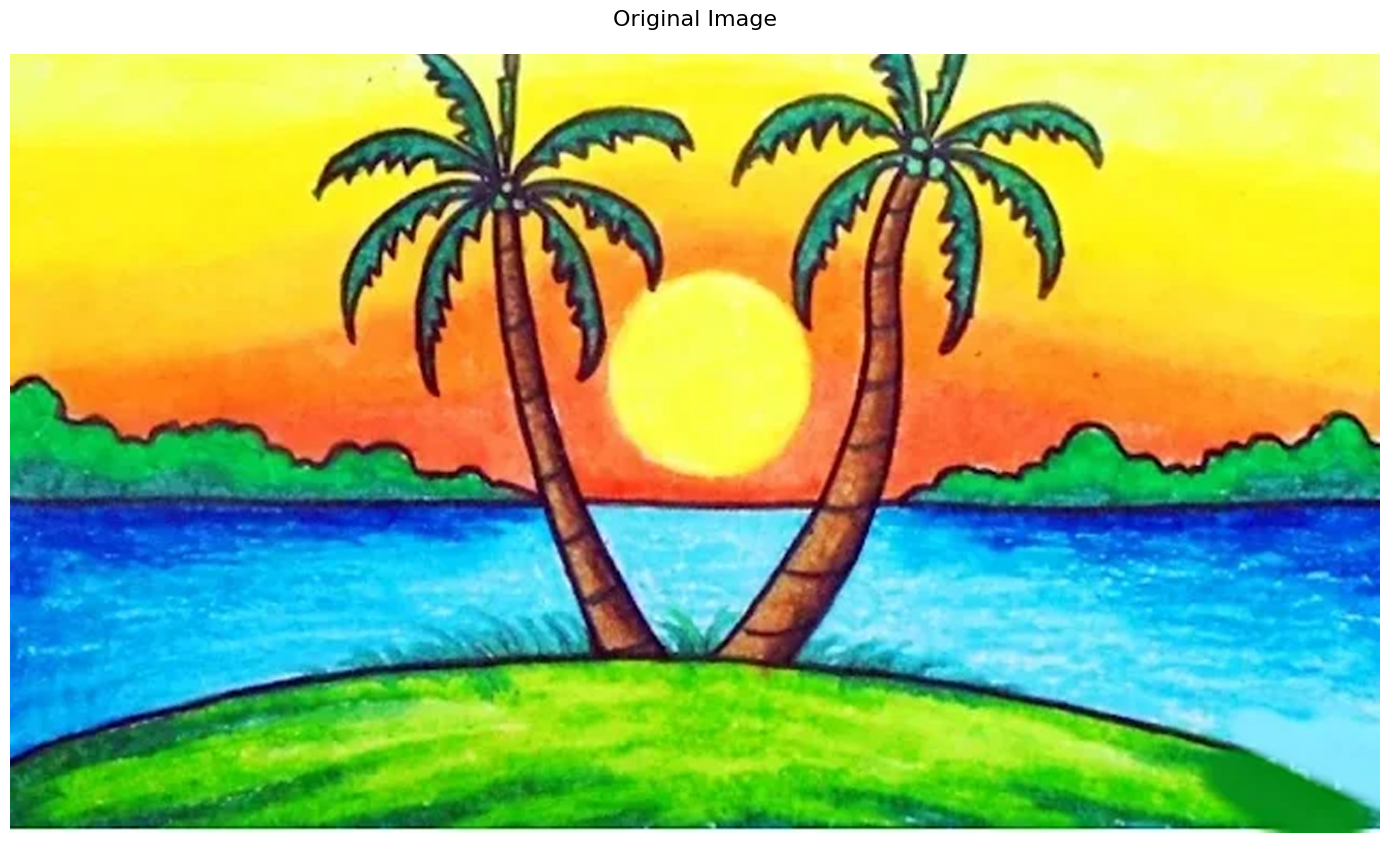


PREVIEW - COLOR PALETTE WITH HEX CODES


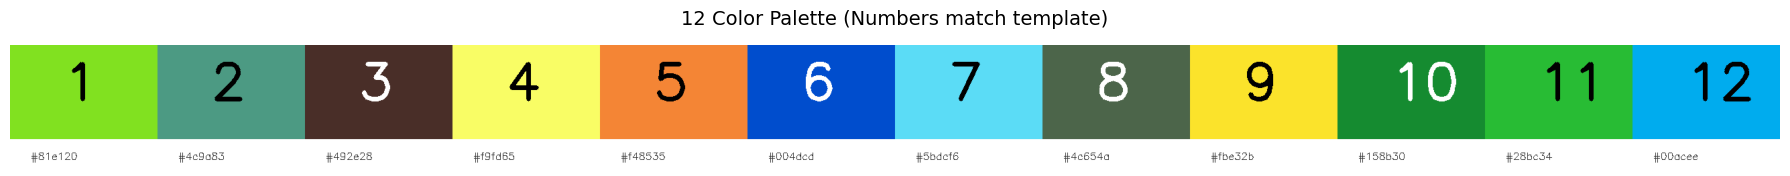


PREVIEW - COLORED REFERENCE


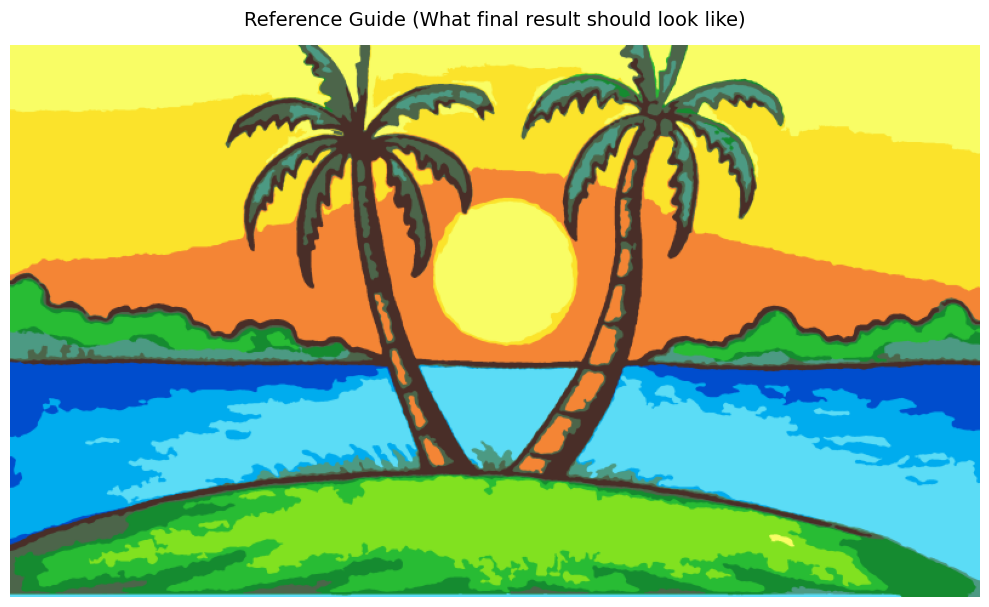


PREVIEW - PAINT-BY-NUMBERS TEMPLATE


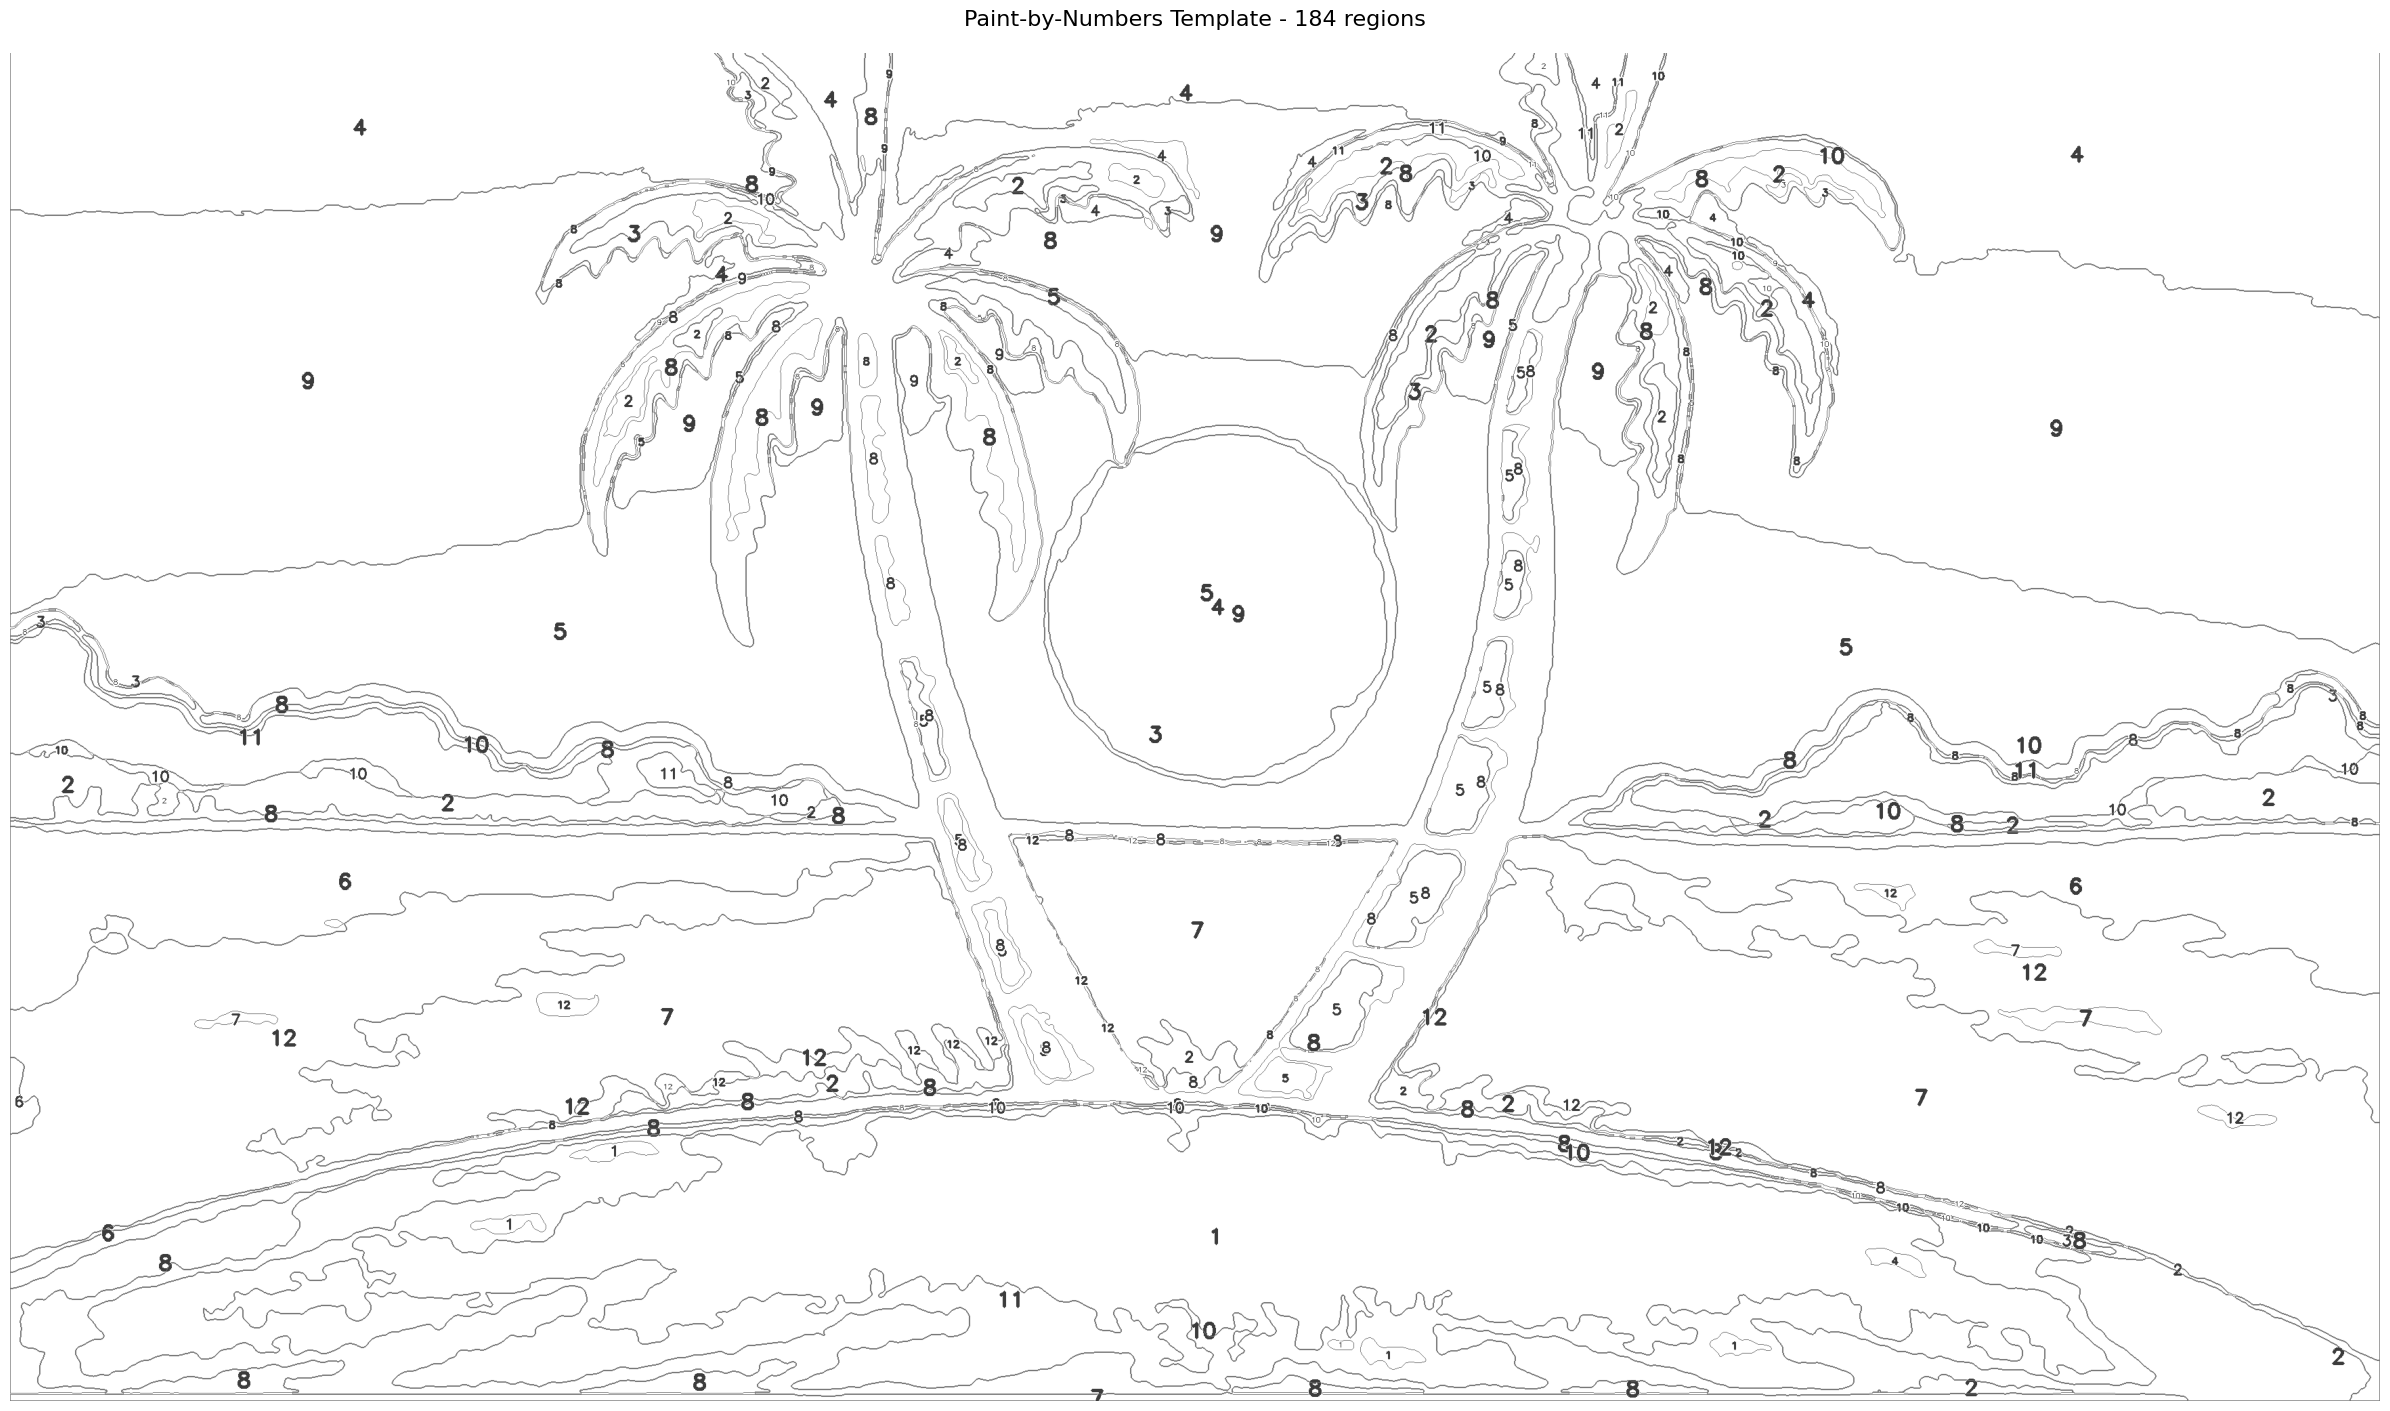

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans
from collections import Counter
from scipy.spatial import distance
import os

def resize_to_target_width(img, target_width=3500):
    """Resizes image preserving aspect ratio."""
    h, w = img.shape[:2]
    scale = target_width / w
    new_w = int(w * scale)
    new_h = int(h * scale)
    return cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_CUBIC)

def get_contrasting_text_color(rgb_color):
    """Returns black or white text color based on background brightness."""
    r, g, b = rgb_color
    luminance = 0.299*r + 0.587*g + 0.114*b
    return (0, 0, 0) if luminance > 128 else (255, 255, 255)

def rgb_to_hex(rgb):
    """Convert RGB tuple to hex string."""
    return '#{:02x}{:02x}{:02x}'.format(int(rgb[0]), int(rgb[1]), int(rgb[2]))

def merge_small_regions_advanced(labels, img_lab, min_size_pixels):
    """Merge small regions based on color similarity in LAB space."""
    print(f"   Merging regions smaller than {min_size_pixels} pixels...")
    h, w = labels.shape
    refined_labels = labels.copy()
    unique_labels = np.unique(refined_labels)

    # Create color map for each label
    label_colors = {}
    for label_id in unique_labels:
        mask = refined_labels == label_id
        label_colors[label_id] = np.mean(img_lab[mask], axis=0)

    for label_id in unique_labels:
        mask = np.uint8(refined_labels == label_id)
        num_labels, blobs, stats, centroids = cv2.connectedComponentsWithStats(mask, connectivity=8)

        for blob_i in range(1, num_labels):
            area = stats[blob_i, cv2.CC_STAT_AREA]
            if area < min_size_pixels:
                blob_mask = np.uint8(blobs == blob_i)
                dilated_mask = cv2.dilate(blob_mask, np.ones((5,5), np.uint8))
                neighbor_pixels = refined_labels[dilated_mask > 0]
                neighbor_pixels = neighbor_pixels[neighbor_pixels != label_id]

                if len(neighbor_pixels) > 0:
                    # Find neighbor with most similar color
                    unique_neighbors = np.unique(neighbor_pixels)
                    current_color = label_colors[label_id]

                    best_neighbor = unique_neighbors[0]
                    min_distance = float('inf')

                    for neighbor_id in unique_neighbors:
                        neighbor_color = label_colors[neighbor_id]
                        color_dist = distance.euclidean(current_color, neighbor_color)
                        if color_dist < min_distance:
                            min_distance = color_dist
                            best_neighbor = neighbor_id

                    refined_labels[blob_mask > 0] = best_neighbor

    return refined_labels

def calculate_difficulty_metrics(labels):
    """Calculate objective difficulty metrics."""
    unique_labels = np.unique(labels)
    region_sizes = []

    for label_id in unique_labels:
        mask = np.uint8(labels == label_id)
        num_labels, blobs, stats, _ = cv2.connectedComponentsWithStats(mask, connectivity=8)
        for blob_i in range(1, num_labels):
            area = stats[blob_i, cv2.CC_STAT_AREA]
            region_sizes.append(area)

    return {
        'total_regions': len(region_sizes),
        'avg_region_size': int(np.mean(region_sizes)),
        'smallest_region': int(np.min(region_sizes)),
        'largest_region': int(np.max(region_sizes))
    }

def place_number_smartly(outline_img, cnt, color_id, font, base_color=(60, 60, 60)):
    """Place numbers with intelligent sizing and white halos for readability."""
    M = cv2.moments(cnt)
    if M["m00"] == 0:
        return

    cX = int(M["m10"] / M["m00"])
    cY = int(M["m01"] / M["m00"])

    # Calculate region size
    (x, y), radius = cv2.minEnclosingCircle(cnt)
    diameter = radius * 2

    if diameter < 35:
        return  # Skip very tiny regions

    # Adaptive font sizing
    if diameter < 60:
        scale = 0.35
        thickness = 1
    elif diameter < 100:
        scale = 0.5
        thickness = 2
    elif diameter < 200:
        scale = 0.7
        thickness = 2
    else:
        scale = 1.0
        thickness = 3

    text_str = str(color_id + 1)
    (text_w, text_h), baseline = cv2.getTextSize(text_str, font, scale, thickness)

    # Ensure text fits
    while text_w > diameter * 0.8 and scale > 0.2:
        scale *= 0.85
        thickness = max(1, thickness - 1)
        (text_w, text_h), baseline = cv2.getTextSize(text_str, font, scale, thickness)

    text_x = cX - int(text_w/2)
    text_y = cY + int(text_h/2)

    # Draw white halo for readability
    cv2.putText(outline_img, text_str, (text_x, text_y),
                font, scale, (255, 255, 255), thickness + 3)
    # Draw actual number
    cv2.putText(outline_img, text_str, (text_x, text_y),
                font, scale, base_color, thickness)

def create_reference_thumbnail(img_rgb, labels, centers_rgb, max_size=800):
    """Create a colored reference thumbnail."""
    h, w = img_rgb.shape[:2]
    scale = min(max_size / w, max_size / h)
    new_w = int(w * scale)
    new_h = int(h * scale)

    # Create colored version
    colored = np.zeros_like(img_rgb)
    for i, color in enumerate(centers_rgb):
        mask = labels == i
        colored[mask] = color

    colored_small = cv2.resize(colored, (new_w, new_h), interpolation=cv2.INTER_AREA)
    return colored_small

def generate_enhanced_pbn(image_path, n_colors=12, difficulty=2, target_width=3500):
    """
    Enhanced paint-by-numbers generator with improved features.

    Parameters:
    - n_colors: Number of colors in palette (recommended 8-20)
    - difficulty: 1=Easy (fewer regions), 2=Medium, 3=Hard (more detail)
    - target_width: Output resolution in pixels (3500 ≈ A3 at 300dpi)
    """

    # 1. Load and Process Image
    print("=" * 60)
    print("PAINT-BY-NUMBERS GENERATOR")
    print("=" * 60)
    print(f"Settings: {n_colors} colors, Difficulty Level {difficulty}")
    print("\n1. Loading and preprocessing image...")

    img_bgr = cv2.imread(image_path)
    if img_bgr is None:
        raise ValueError(f"Could not load image: {image_path}")

    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    img_rgb = resize_to_target_width(img_rgb, target_width=target_width)
    h, w, c = img_rgb.shape
    print(f"   Output size: {w} x {h} pixels")

    # 2. Advanced smoothing with edge preservation
    print("2. Applying edge-preserving smoothing...")
    img_smooth = cv2.bilateralFilter(img_rgb, d=15, sigmaColor=80, sigmaSpace=80)

    # 3. Color quantization using Mini-Batch K-Means (faster)
    print(f"3. Extracting {n_colors}-color palette...")
    img_lab = cv2.cvtColor(img_smooth, cv2.COLOR_RGB2LAB)
    img_flat = img_lab.reshape((-1, 3))

    # Use mini-batch for speed
    sample_size = min(len(img_flat), 10000)
    train_pixels = img_flat[np.random.choice(len(img_flat), sample_size, replace=False)]

    kmeans = MiniBatchKMeans(n_clusters=n_colors, random_state=42,
                             batch_size=1000, n_init=10)
    kmeans.fit(train_pixels)

    labels_flat = kmeans.predict(img_flat)
    centers_lab = kmeans.cluster_centers_.astype("uint8")
    centers_rgb = [cv2.cvtColor(np.uint8([[lab]]), cv2.COLOR_LAB2RGB)[0][0] for lab in centers_lab]
    labels = labels_flat.reshape((h, w))

    # 4. Intelligent region merging
    print("4. Optimizing regions...")
    if difficulty == 1:
        min_px = int(h * w * 0.0008)  # ~0.08% of image
    elif difficulty == 3:
        min_px = int(h * w * 0.0002)  # ~0.02% of image
    else:
        min_px = int(h * w * 0.0004)  # ~0.04% of image

    labels_cleaned = merge_small_regions_advanced(labels, img_lab, min_px)

    # 5. Calculate difficulty metrics
    metrics = calculate_difficulty_metrics(labels_cleaned)
    print("\n" + "=" * 60)
    print("DIFFICULTY ANALYSIS")
    print("=" * 60)
    print(f"Total regions to paint: {metrics['total_regions']}")
    print(f"Average region size: {metrics['avg_region_size']} pixels")
    print(f"Smallest region: {metrics['smallest_region']} pixels")
    print(f"Largest region: {metrics['largest_region']} pixels")

    # 6. Generate high-quality outline with smart number placement
    print("\n5. Generating paint-by-numbers template...")
    outline_img = np.ones((h, w, 3), dtype=np.uint8) * 255
    font = cv2.FONT_HERSHEY_SIMPLEX

    for color_id in range(n_colors):
        mask = np.uint8(labels_cleaned == color_id)
        mask = cv2.medianBlur(mask, 5)
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Adaptive line thickness based on image size
        line_thickness = max(1, int(h / 1500))
        cv2.drawContours(outline_img, contours, -1, (120, 120, 120), line_thickness)

        for cnt in contours:
            place_number_smartly(outline_img, cnt, color_id, font)

    # 7. Generate enhanced palette with color codes
    print("6. Creating color palette guide...")
    block_h = 180
    block_w = 220
    palette_img = np.ones((block_h, block_w * n_colors, 3), dtype=np.uint8) * 255

    for i, color in enumerate(centers_rgb):
        x_start = i * block_w
        x_end = (i + 1) * block_w

        # Color block
        palette_img[:block_h-40, x_start:x_end] = color

        # Number label
        text_color = get_contrasting_text_color(color)
        cv2.putText(palette_img, str(i + 1), (x_start + 80, 80),
                    font, 2.5, text_color, 6)

        # Hex code at bottom
        hex_code = rgb_to_hex(color)
        cv2.putText(palette_img, hex_code, (x_start + 30, block_h - 10),
                    font, 0.5, (50, 50, 50), 1)

    # 8. Create reference thumbnail
    print("7. Generating reference image...")
    reference_img = create_reference_thumbnail(img_rgb, labels_cleaned, centers_rgb)

    print("\n" + "=" * 60)
    print("GENERATION COMPLETE!")
    print("=" * 60)

    return img_rgb, palette_img, outline_img, reference_img, metrics

# --- EXECUTION ---
if 'image_path' in locals():
    try:
        print("Select difficulty:")
        print("1 = Easy (fewer, larger regions)")
        print("2 = Medium (balanced)")
        print("3 = Hard (more detail, smaller regions)")
        lvl = int(input("Enter difficulty (1-3): "))
        lvl = max(1, min(3, lvl))
    except:
        lvl = 2

    try:
        n_colors = int(input(f"Number of colors (8-20, recommended {12}): "))
        n_colors = max(8, min(20, n_colors))
    except:
        n_colors = 12

    # Generate
    orig, palette, template, reference, metrics = generate_enhanced_pbn(
        image_path, n_colors=n_colors, difficulty=lvl
    )

    # Save outputs
    cv2.imwrite("1_original_reference.png", cv2.cvtColor(orig, cv2.COLOR_RGB2BGR))
    cv2.imwrite("2_color_palette.png", cv2.cvtColor(palette, cv2.COLOR_RGB2BGR))
    cv2.imwrite("3_paint_template.png", cv2.cvtColor(template, cv2.COLOR_RGB2BGR))
    cv2.imwrite("4_colored_reference.png", cv2.cvtColor(reference, cv2.COLOR_RGB2BGR))

    print("\nFiles saved:")
    print("  - 1_original_reference.png (Original image)")
    print("  - 2_color_palette.png (Color guide with hex codes)")
    print("  - 3_paint_template.png (Main template to print)")
    print("  - 4_colored_reference.png (Colored reference thumbnail)")

    # Display
    print("\n" + "=" * 60)
    print("PREVIEW - ORIGINAL IMAGE")
    print("=" * 60)
    plt.figure(figsize=(14, 10))
    plt.imshow(orig)
    plt.axis('off')
    plt.title("Original Image", fontsize=16, pad=20)
    plt.tight_layout()
    plt.show()

    print("\n" + "=" * 60)
    print("PREVIEW - COLOR PALETTE WITH HEX CODES")
    print("=" * 60)
    plt.figure(figsize=(18, 3))
    plt.imshow(palette)
    plt.axis('off')
    plt.title(f"{n_colors} Color Palette (Numbers match template)", fontsize=14, pad=15)
    plt.tight_layout()
    plt.show()

    print("\n" + "=" * 60)
    print("PREVIEW - COLORED REFERENCE")
    print("=" * 60)
    plt.figure(figsize=(10, 10))
    plt.imshow(reference)
    plt.axis('off')
    plt.title("Reference Guide (What final result should look like)", fontsize=14, pad=15)
    plt.tight_layout()
    plt.show()

    print("\n" + "=" * 60)
    print("PREVIEW - PAINT-BY-NUMBERS TEMPLATE")
    print("=" * 60)
    plt.figure(figsize=(24, 24))
    plt.imshow(template)
    plt.axis('off')
    plt.title(f"Paint-by-Numbers Template - {metrics['total_regions']} regions",
              fontsize=16, pad=20)
    plt.tight_layout()
    plt.show()

else:
    print("Please upload an image and set 'image_path' variable.")